# Attention is all you need
## Transformers from scratch

## Importing some libraries and dataset 

In [ ]:
import torch
import spacy
!pip install torchtext==0.6.0
from torchtext.datasets import Multi30k
from torchtext.data import Field,BucketIterator

     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 1.2MB 12.2MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [ ]:
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 7.7MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp37-none-any.whl size=14907057 sha256=7384beaecc7988f79b2c4479c7d4ce077e5c70289e7df9c8245705aede8f9b83
  Stored in directory: /tmp/pip-ephem-wheel-cache-p10l345j/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [ ]:
spacy_eng = spacy.load('en')
spacy_ger = spacy.load('de')

In [ ]:
def tokenize_eng(text):
    return([tok.text for tok in spacy_eng.tokenizer(text)])
def tokenize_ger(text):
    return([tok.text for tok in spacy_ger.tokenizer(text)])

In [ ]:
english = Field(sequential=True, use_vocab=True, tokenize=tokenize_eng, lower=True,init_token='<sos>',eos_token='<eos>',batch_first=True)
german = Field(sequential=True, use_vocab=True, tokenize=tokenize_ger, lower=True,init_token='<sos>',eos_token='<eos>',batch_first=True)

train_data, validation_data, test_data = Multi30k.splits(exts=('.de','.en'),fields=(german,english))

english.build_vocab(train_data,max_size=10000,min_freq=2)
german.build_vocab(train_data,max_size=10000,min_freq=2)

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 559kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 169kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 167kB/s]


In [ ]:
english.vocab.stoi['<pad>']
german.vocab.stoi['<pad>']

1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

## Model building and some helper functions 

In [ ]:
def validation_loss(model,validation_iterator):
    epoch_loss = []
    for batch in validation_iterator:
        batch_loss = []
        source = batch.src
        target = batch.trg   #target = encseq_len, batch
            #print(target.shape)
        batch_size = source.shape[0]
        enc,out = model(source,target[:,:-1])   # out = dec_seq_len, batch, output_size    
            #print(out.shape)
            #print(target.shape)    
        model.zero_grad()
        optimizer.zero_grad()
                
        out = out.view(-1,out_vocab_size)
        target = target[:,1:].reshape(-1)
            #print(out.shape)
            #print(target.shape)  
        loss = criterion(out,target)
        batch_loss.append(loss.item())
        epoch_loss += batch_loss
    return (epoch_loss)

Encoder class is the block which takes source sentences , mapps their attention and applies a add and norm layer at the end

Here , Linear layers are used for creating distinct attention heads. These will be used to calculate attention outputs and these outputs will be concatenated . Here , number of heads were kept 4 to obtained the best results.

After applying residual connections , normalization is done. It was observed that dropout of 0.22 was giving best results over this structure.
We tryied creating only one linear layer such that its output can be reshaped as multiple heads but making distinct heads were able to build perfect mapping between words in sentences.

You can see function for calculating multihead attention are methods of Encoder and Decoder class.

In [157]:
class Encoder(nn.Module):

    def __init__(self,batch_size,d_model,d_k,n_dk):
        super(Encoder,self).__init__()
        self.batch_size = batch_size
        self.d_model = d_model                 #embedding_dim
        self.d_k = d_k                         #querries and keys dimension.
        self.n_dk = n_dk

        self.dropout = nn.Dropout(0.22)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)


        self.WQ1 =  nn.Linear(d_model,d_k)
        self.WK1 = nn.Linear(d_model,d_k)
        self.WV1 = nn.Linear(d_model,d_k)

        self.WQ2 =  nn.Linear(d_model,d_k)
        self.WK2 = nn.Linear(d_model,d_k)
        self.WV2 = nn.Linear(d_model,d_k)

        self.WQ3 =  nn.Linear(d_model,d_k)
        self.WK3 = nn.Linear(d_model,d_k)
        self.WV3 = nn.Linear(d_model,d_k)

        self.WQ4 =  nn.Linear(d_model,d_k)
        self.WK4 = nn.Linear(d_model,d_k)
        self.WV4 = nn.Linear(d_model,d_k)

        
        self.W0 = nn.Linear(n_dk*d_k,d_model)

        self.softmax = nn.Softmax(dim=-1)
        self.ff_enc1 = nn.Linear(d_model,d_model*2)
        self.ff_enc2 = nn.Linear(d_model*2,d_model)
        self.relu = nn.ReLU()

    def multihead(self,x,mask):
        q1 = self.WQ1(x)
        k1 = self.WK1(x)
        v1 = self.WV1(x)

        q2 = self.WQ2(x)
        k2 = self.WK2(x)
        v2 = self.WV2(x)

        q3 = self.WQ3(x)
        k3 = self.WK3(x)
        v3 = self.WV3(x)

        q4 = self.WQ4(x)
        k4 = self.WK4(x)
        v4 = self.WV4(x)
        
        z1=torch.matmul(self.softmax((torch.matmul(q1,torch.transpose(k1,1,2))/(self.d_k**0.5)).masked_fill(mask==False,-1e10)),v1)
        z2=torch.matmul(self.softmax((torch.matmul(q2,torch.transpose(k2,1,2))/(self.d_k**0.5)).masked_fill(mask==False,-1e10)),v2)
        z3=torch.matmul(self.softmax((torch.matmul(q3,torch.transpose(k3,1,2))/(self.d_k**0.5)).masked_fill(mask==False,-1e10)),v3)
        z4=torch.matmul(self.softmax((torch.matmul(q4,torch.transpose(k4,1,2))/(self.d_k**0.5)).masked_fill(mask==False,-1e10)),v4)

        z = torch.cat((z1,z2,z3,z4),dim=-1)
        z = self.W0(z)
        return (z)

    def forward(self,x,mask):
          
        x = self.dropout(self.multihead(x,mask)) + x
        x = self.norm1(x)
        x = self.dropout(self.relu(self.ff_enc2(self.dropout(self.relu(self.ff_enc1(x)))))) + x
        x = self.norm2(x)
        
        return (x)

Decoder block takes target sentence embeddings ,finds self attention , finds attention with encoder's last layer, and then feed forward layer. After every operation, residual connection is obtained and layer normalization is applied. Here also distict heads were giving good results. Number of heads is kept 4 to obtain best results.

In [ ]:
class Decoder(nn.Module):
  
    def __init__(self,batch_size,d_model,d_k,n_d_k):
        super(Decoder,self).__init__()
        self.batch_size = batch_size
        self.d_model = d_model                 #embedding_dim
        self.d_k = d_k                         #querries and keys dimension.
        self.n_dk = n_dk

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)


        self.dropout = nn.Dropout(0.22)
        self.WQ1 =  nn.Linear(d_model,d_k)
        self.WK1 = nn.Linear(d_model,d_k)
        self.WV1 = nn.Linear(d_model,d_k)

        self.WQ2 =  nn.Linear(d_model,d_k)
        self.WK2 = nn.Linear(d_model,d_k)
        self.WV2 = nn.Linear(d_model,d_k)

        self.WQ3 =  nn.Linear(d_model,d_k)
        self.WK3 = nn.Linear(d_model,d_k)
        self.WV3 = nn.Linear(d_model,d_k)

        self.WQ4 =  nn.Linear(d_model,d_k)
        self.WK4 = nn.Linear(d_model,d_k)
        self.WV4 = nn.Linear(d_model,d_k)

        self.W0 = nn.Linear(n_dk*d_k,d_model)

        self.EDWQ1 =  nn.Linear(d_model,d_k)
        self.EDWK1 = nn.Linear(d_model,d_k)
        self.EDWV1 = nn.Linear(d_model,d_k)

        self.EDWQ2 =  nn.Linear(d_model,d_k)
        self.EDWK2 = nn.Linear(d_model,d_k)
        self.EDWV2 = nn.Linear(d_model,d_k)

        self.EDWQ3 =  nn.Linear(d_model,d_k)
        self.EDWK3 = nn.Linear(d_model,d_k)
        self.EDWV3 = nn.Linear(d_model,d_k)

        self.EDWQ4 =  nn.Linear(d_model,d_k)
        self.EDWK4 = nn.Linear(d_model,d_k)
        self.EDWV4 = nn.Linear(d_model,d_k)

        self.EDW0 = nn.Linear(n_dk*d_k,d_model)

        self.softmax = nn.Softmax(dim=-1)
        self.ff_dec1 = nn.Linear(d_model,2*d_model)
        self.ff_dec2 = nn.Linear(2*d_model,d_model)
        self.relu = nn.ReLU()

    def masked_multihead(self,x,mask):
        q1 = self.WQ1(x)
        k1 = self.WK1(x)
        v1 = self.WV1(x)

        q2 = self.WQ2(x)
        k2 = self.WK2(x)
        v2 = self.WV2(x)

        q3 = self.WQ3(x)
        k3 = self.WK3(x)
        v3 = self.WV3(x)

        q4 = self.WQ4(x)
        k4 = self.WK4(x)
        v4 = self.WV4(x)
        
        z1=torch.matmul(self.softmax((torch.matmul(q1,torch.transpose(k1,1,2))/(self.d_k**0.5)).masked_fill(mask==False,-1e10)),v1)
        z2=torch.matmul(self.softmax((torch.matmul(q2,torch.transpose(k2,1,2))/(self.d_k**0.5)).masked_fill(mask==False,-1e10)),v2)
        z3=torch.matmul(self.softmax((torch.matmul(q3,torch.transpose(k3,1,2))/(self.d_k**0.5)).masked_fill(mask==False,-1e10)),v3)
        z4=torch.matmul(self.softmax((torch.matmul(q4,torch.transpose(k4,1,2))/(self.d_k**0.5)).masked_fill(mask==False,-1e10)),v4)

        z = torch.cat((z1,z2,z3,z4),dim=-1)
        z = self.W0(z)
        return (z)
        

    def multihead(self,x,enc,mask):
        q1 = self.EDWQ1(x)
        k1 = self.EDWK1(enc)
        v1 = self.EDWV1(enc)

        q2 = self.EDWQ2(x)
        k2 = self.EDWK2(enc)
        v2 = self.EDWV2(enc)

        q3 = self.EDWQ3(x)
        k3 = self.EDWK3(enc)
        v3 = self.EDWV3(enc)

        q4 = self.EDWQ4(x)
        k4 = self.EDWK4(enc)
        v4 = self.EDWV4(enc)
        
        # print(q1.shape,k1.shape)
        z1 = torch.matmul(q1,torch.transpose(k1,1,2))/(self.d_k**0.5)
        z1=torch.matmul(self.softmax(z1.masked_fill(mask==False,-1e10)),v1)
        z2=torch.matmul(self.softmax((torch.matmul(q2,torch.transpose(k2,1,2))/(self.d_k**0.5)).masked_fill(mask==False,-1e10)),v2)
        z3=torch.matmul(self.softmax((torch.matmul(q3,torch.transpose(k3,1,2))/(self.d_k**0.5)).masked_fill(mask==False,-1e10)),v3)
        z4=torch.matmul(self.softmax((torch.matmul(q4,torch.transpose(k4,1,2))/(self.d_k**0.5)).masked_fill(mask==False,-1e10)),v4)

        z = torch.cat((z1,z2,z3,z4),dim=-1)
        z = self.EDW0(z)
        return (z)

    def forward(self,x,enc,trg_mask,src_mask):
        
        x = self.dropout(self.masked_multihead(x,trg_mask)) + x
        x = self.norm1(x)
        x = self.dropout(self.multihead(x,enc,src_mask)) + x
        x = self.norm2(x)
        x = self.dropout(self.relu(self.ff_dec2(self.dropout(self.relu(self.ff_dec1(x)))))) + x
        x = self.norm3(x)
        return (x)


Transformer block takes source and target encodings as input , fetches their embeddings , add seperate positional embeddings and pass source through Encoder and target, output of Encoder's last layer through Decoder. Within Transformer class , you can create multiple layers of encoder and decoder and stack them on top of each othe.

Remember, Embeddings are not part of Encoding or decoding. Also mask creating fuctions are methods of Transformer class.

In [ ]:
class Transformer(nn.Module):

    def __init__(self,batch_size,in_vocab_size,out_vocab_size,d_model,d_k,n_dk,device):
        super(Transformer,self).__init__()
        self.in_vocab_size = in_vocab_size     #input vocab size
        self.out_vocab_size = out_vocab_size     #input vocab size
        self.batch_size = batch_size
        self.d_k = d_k
        self.d_model = d_model
        self.device = device
        self.n_dk = n_dk

        self.enc_embeddings = nn.Embedding(in_vocab_size,d_model)
        self.dec_embeddings = nn.Embedding(out_vocab_size,d_model)
        self.pe_embeddings_enc = nn.Embedding(100,d_model)
        self.pe_embeddings_dec = nn.Embedding(100,d_model)

        self.encoder1 = Encoder(batch_size,d_model,d_k,n_dk)
        # self.encoder2 = Encoder(batch_size,d_model,d_k,n_dk)
        # self.encoder3 = Encoder(batch_size,d_model,d_k,n_dk)
        # self.encoder4 = Encoder(batch_size,d_model,d_k,n_dk)

        self.decoder1 = Decoder(batch_size,d_model,d_k,n_dk)
        # self.decoder2 = Decoder(batch_size,d_model,d_k,n_dk)
        # self.decoder3 = Decoder(batch_size,d_model,d_k,n_dk)
        # self.decoder4 = Decoder(batch_size,d_model,d_k,n_dk)

        self.linear = nn.Linear(d_model,out_vocab_size)
        self.softmax = nn.Softmax(dim=-1)

    def make_src_mask(self, src):                                                       # src = [batch_size, src_len]
        src_mask = (src != 1).unsqueeze(1).to(device)   # src_mask = [batch_size, 1, src_len]
        return src_mask

    def make_trg_mask(self, trg):                                                       # trg = [batch_size, trg_len]                  
        trg_len = trg.shape[1] 
        pad_mask = (trg != 1).unsqueeze(1).to(device)   # pad_mask = [batch_size, 1, trg_len]
        sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = device)).bool()   # sub_mask = [trg_len, trg_len]
        trg_mask = pad_mask & sub_mask                                                  # trg_mask = [batch_size, trg_len, trg_len]
        return trg_mask

    def forward(self,src,trg):
        seq_len = src.shape[1]
        batch_size = src.shape[0]
        src_mask = self.make_src_mask(src)
        enc = self.enc_embeddings(src)
        PE1 = torch.arange(seq_len).unsqueeze(0).repeat(batch_size,1).to(device)
        PE1 = self.pe_embeddings_enc(PE1)
        enc = enc*(self.d_k**0.5) + PE1
        enc = self.encoder1(enc,src_mask)
        # enc = self.encoder2(enc,src_mask)
        # enc = self.encoder3(enc,src_mask)
        # enc = self.encoder4(enc,src_mask)

        seq_len = trg.shape[1]
        trg_mask = self.make_trg_mask(trg)
        dec = self.dec_embeddings(trg)
        PE2 = torch.arange(seq_len).unsqueeze(0).repeat(batch_size,1).to(device)
        PE2 = self.pe_embeddings_dec(PE2)
        dec = dec*(self.d_k**0.5) + PE2
        dec = self.decoder1(dec,enc,trg_mask,src_mask)
        # dec = self.decoder2(dec,enc,trg_mask,src_mask)
        # dec = self.decoder3(dec,enc,trg_mask,src_mask)
        # dec = self.decoder4(dec,enc,trg_mask,src_mask)
        dec = self.linear(dec)
        return (enc,dec)


### Some hyperparameters 

In [ ]:
d_model = 512   # embedding dimension
d_k = 64
n_dk = 4
in_vocab_size = len(german.vocab)
out_vocab_size = len(english.vocab)
batch_size = 128
device = 'cuda' if torch.cuda.is_available else 'cpu'
learning_rate = 0.0004
epochs = 13

In [ ]:
#d_model=512,d_k=64,n_dk=4,batch=128,lr=0.0004,epochs=5 gave the best results till now with single layer
# ...................................................................................................................................................................................................................................
# epoch train loss : 2.0330910236299826  ||  time : 15.214810371398926  ||  epoch validation loss : 2.014664277434349
# ...................................................................................................................................................................................................................................
# epoch train loss : 1.1160743593644467  ||  time : 15.319031000137329  ||  epoch validation loss : 1.5752189457416534
# ...................................................................................................................................................................................................................................
# epoch train loss : 0.82381343473947  ||  time : 15.492727041244507  ||  epoch validation loss : 1.4209523051977158
# ...................................................................................................................................................................................................................................
# epoch train loss : 0.645236498458795  ||  time : 15.51793885231018  ||  epoch validation loss : 1.3809292763471603
# ...................................................................................................................................................................................................................................
# epoch train loss : 0.5199730066738465  ||  time : 15.513466835021973  ||  epoch validation loss : 1.386391267180442
#separated model

In [ ]:
train_iterator, validation_iterator, test_iterator = BucketIterator.splits((train_data,validation_data,test_data),
                                                                          batch_size=batch_size,device=device)

In [ ]:
model = Transformer(batch_size,in_vocab_size,out_vocab_size,d_model,d_k,n_dk,device).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,846,533 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (enc_embeddings): Embedding(7855, 512)
  (dec_embeddings): Embedding(5893, 512)
  (pe_embeddings_enc): Embedding(100, 512)
  (pe_embeddings_dec): Embedding(100, 512)
  (encoder1): Encoder(
    (dropout): Dropout(p=0.22, inplace=False)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (WQ1): Linear(in_features=512, out_features=64, bias=True)
    (WK1): Linear(in_features=512, out_features=64, bias=True)
    (WV1): Linear(in_features=512, out_features=64, bias=True)
    (WQ2): Linear(in_features=512, out_features=64, bias=True)
    (WK2): Linear(in_features=512, out_features=64, bias=True)
    (WV2): Linear(in_features=512, out_features=64, bias=True)
    (WQ3): Linear(in_features=512, out_features=64, bias=True)
    (WK3): Linear(in_features=512, out_features=64, bias=True)
    (WV3): Linear(in_features=512, out_features=64, bias=True)
    (WQ4): Linear(in_features=512, out_features=6

## Training 

In [ ]:
train_loss_lst = []
validation_loss_lst = []
for epoch in range(epochs):
    epoch_loss = []
    t1 = time.time()
    for batch in train_iterator:
        t11 = time.time()

        source = batch.src
        target = batch.trg   #target = batch x seqlen
        
        model.zero_grad()
        optimizer.zero_grad()

        _,out = model(source,target[:,:-1])

        out = out.view(-1,out_vocab_size)
        target = target[:,1:].reshape(-1)

        loss = criterion(out,target)
        epoch_loss.append(loss.item())

        loss.backward()
        optimizer.step()
        t22 = time.time()
        print(".",end="")
    train_loss_lst += epoch_loss
    t2 = time.time()
    validation_lst = validation_loss(model,validation_iterator)
    validation_loss_lst += validation_lst

    print()
    print("epoch train loss : {}  ||  time : {}  ||  epoch validation loss : {}".format(np.mean(epoch_loss),t2-t1,np.mean(validation_lst)))

...................................................................................................................................................................................................................................
epoch train loss : 2.0330910236299826  ||  time : 15.214810371398926  ||  epoch validation loss : 2.014664277434349
...................................................................................................................................................................................................................................
epoch train loss : 1.1160743593644467  ||  time : 15.319031000137329  ||  epoch validation loss : 1.5752189457416534
...................................................................................................................................................................................................................................
epoch train loss : 0.82381343473947  ||  time : 15.492727041244507  ||  epoch valid

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(),'Transformer_sep1.pth')

d_model = 256   # embedding dimension
d_k = 64
n_dk = 6
in_vocab_size = len(german.vocab)
out_vocab_size = len(english.vocab)
batch_size = 128
device = 'cuda' if torch.cuda.is_available else 'cpu'
learning_rate = 0.0005
epochs = 13

#### If dont want to train, you can load it from here also 

In [ ]:
model.load_state_dict(torch.load('Transformer_sep1.pth'))

<All keys matched successfully>

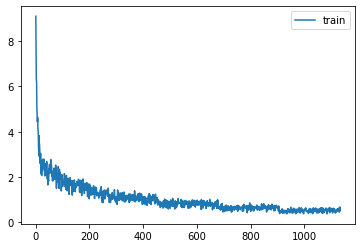

In [ ]:


plt.plot(train_loss_lst)
plt.legend(['train'])

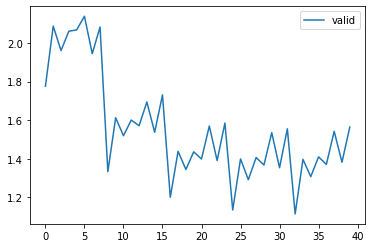

In [ ]:
plt.plot(validation_loss_lst)
plt.legend(['valid'])

### Testing over some random sentences 

In [170]:
#sentence = 'ich habe kein interesse am spielen .' # 'i dont have intrest in playing'
#sentence = 'ich bin heute glücklich .'  # 'i am happy today'
#sentence = 'eine frau mochte dieses gebäude .' # 'a woman liked that building'
#sentence = 'eines tages werde ich reich sein .'  # 'one day i will be rich'
sentence = 'ein mann lehnt sich in der nähe einer belebten straße an ein gebäude .'  # 'a man leans against a building near a busy street .'
#sentence = 'wer bin ich .'   # 'who am i'
#sentence = 'ein läufer <unk> sich für ein rennen aus dem <unk> .'  #runner leaving the starting blocks of a race .
sentence = sentence.split()
inputs = torch.zeros([len(sentence)+2],dtype=torch.long)
inputs[0] = 2
inputs[-1]  = 3
#a[1] = 1180
for i in range(0,len(sentence)):

    inputs[i+1] = german.vocab.stoi[sentence[i]]
    
print(inputs)
print(sentence)

tensor([  2,   5,  13, 287,  23,   7,  15, 110,  14, 340,  34,  21,   5, 104,
          4,   3])
['ein', 'mann', 'lehnt', 'sich', 'in', 'der', 'nähe', 'einer', 'belebten', 'straße', 'an', 'ein', 'gebäude', '.']


In [171]:
translation = ''
trg = []
word = '<sos>'
word_index = 2
count=0
trg.append(word_index)
src = inputs.reshape(1,-1).to(device)

seq_len = src.shape[1]
batch_size = src.shape[0]
src_mask = model.make_src_mask(src)
enc = model.enc_embeddings(src)
PE1 = torch.arange(seq_len).unsqueeze(0).repeat(batch_size,1).to(device)
PE1 = model.pe_embeddings_enc(PE1)
enc = enc*(d_k**0.5) + PE1
enc = model.encoder1(enc,src_mask)

while (word!='<eos>' and count<=50):
    seq_len = count+1
    trg_mask = model.make_trg_mask(torch.tensor(trg).reshape(1,-1)).to(device)
    dec = model.dec_embeddings(torch.tensor(trg).reshape(1,-1).to(device))    
    PE2 = torch.arange(seq_len).unsqueeze(0).repeat(batch_size,1).to(device)
    PE2 = model.pe_embeddings_dec(PE2)
    dec = dec*(d_k**0.5) + PE2
    dec = model.decoder1(dec,enc,trg_mask,src_mask)
    dec = model.linear(dec)

    word_index = torch.argmax(dec[0,-1,:]).item()
    word = english.vocab.itos[word_index]
    if (word!='<eos>'):
        translation = translation + " " + word
        trg.append(word_index)
        count +=1
print(translation)

 a man leaning against a building near a busy street .


## BLEU score

In [ ]:
out = model(inputs.reshape(1,-1).to(device),torch.tensor([[word_index]]).to(device))
out = model.softmax(out)
word_index = torch.argmax(out).item()
word = english.vocab.itos[word_index]

In [ ]:
def encodings(src,trg):
    src_enc = torch.zeros([len(src)+2],dtype=torch.long)
    trg_enc = torch.zeros([len(trg)+2],dtype=torch.long)
    src_enc[0] = 2
    src_enc[-1] = 3
    trg_enc[0] = 2
    trg_enc[-1] = 3
    for i in range(len(src)):
        src_enc[i+1] = german.vocab.stoi[src[i]]
    for i in range(len(trg)):
        trg_enc[i+1] = english.vocab.stoi[trg[i]]
    return(src_enc,trg_enc)

In [ ]:
from torchtext.data.metrics import bleu_score

In [158]:
predicted_target = []
target = []
for n,i in enumerate(test_data):
    src = vars(test_data[n])['src']
    t = vars(test_data[n])['trg']

    src_enc,trg_enc = encodings(src,t)
    inputs = torch.tensor(src_enc)


    translation = []
    trg = []
    word = '<sos>'
    word_index = 2
    count=0
    trg.append(word_index)
    src = inputs.reshape(1,-1).to(device)


    seq_len = src.shape[1]
    batch_size = src.shape[0]
    src_mask = model.make_src_mask(src)
    enc = model.enc_embeddings(src)
    PE1 = torch.arange(seq_len).unsqueeze(0).repeat(batch_size,1).to(device)
    PE1 = model.pe_embeddings_enc(PE1)
    enc = enc*(d_k**0.5) + PE1
    enc = model.encoder1(enc,src_mask)
    # enc = model.encoder2(enc,src_mask)
    # enc = model.encoder3(enc,src_mask)
    # enc = model.encoder4(enc,src_mask)

    while (word!='<eos>' and count<=50):
        seq_len = count+1
        trg_mask = model.make_trg_mask(torch.tensor(trg).reshape(1,-1)).to(device)
        dec = model.dec_embeddings(torch.tensor(trg).reshape(1,-1).to(device))    
        PE2 = torch.arange(seq_len).unsqueeze(0).repeat(batch_size,1).to(device)
        PE2 = model.pe_embeddings_dec(PE2)
        dec = dec*(d_k**0.5) + PE2
        dec = model.decoder1(dec,enc,trg_mask,src_mask)
        # dec = model.decoder2(dec,enc,trg_mask,src_mask)
        # dec = model.decoder3(dec,enc,trg_mask,src_mask)
        # dec = model.decoder4(dec,enc,trg_mask,src_mask)
        dec = model.linear(dec)

        word_index = torch.argmax(dec[0,-1,:]).item()
        word = english.vocab.itos[word_index]
        if (word!='<eos>'):
            translation.append(word)
            trg.append(word_index)
            count +=1

    target.append([t])
    predicted_target.append(translation)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [159]:
bscore = bleu_score(predicted_target, target)
print(f"BLEU score on Testing Data: {bscore*100:.2f}")

BLEU score on Testing Data: 32.82


BLEU score of 32.82 was achieved over test data

### Some sentences and predicted translations 

In [160]:
for i in range(10):
  print(predicted_target[i])
  print(target[i])
  print()

['a', 'man', 'in', 'an', 'orange', 'hat', ',', 'orange', 'and', 'white', '<unk>', '.']
[['a', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something', '.']]

['a', 'boston', '<unk>', 'terrier', 'runs', 'over', 'grass', 'in', 'front', 'of', 'a', 'white', 'fence', '.']
[['a', 'boston', 'terrier', 'is', 'running', 'on', 'lush', 'green', 'grass', 'in', 'front', 'of', 'a', 'white', 'fence', '.']]

['a', 'girl', 'in', 'a', 'karate', 'uniform', 'is', 'doing', 'a', 'trick', '.']
[['a', 'girl', 'in', 'karate', 'uniform', 'breaking', 'a', 'stick', 'with', 'a', 'front', 'kick', '.']]

['five', 'people', 'in', 'winter', 'jackets', 'with', 'helmets', 'standing', 'in', 'the', 'snow', 'with', 'helmets', 'in', 'the', 'background', '.']
[['five', 'people', 'wearing', 'winter', 'jackets', 'and', 'helmets', 'stand', 'in', 'the', 'snow', ',', 'with', 'snowmobiles', 'in', 'the', 'background', '.']]

['people', 'fixing', 'the', 'roof', 'of', 'a', 'house', '.']
[['people', 'are', 'fixing', 'the', '

In [172]:
for i in range(20,40):
    print(predicted_target[i])
    print(target[i])
    print()

['people', 'standing', 'in', 'front', 'of', 'a', 'building', '.']
[['people', 'standing', 'outside', 'of', 'a', 'building', '.']]

['a', 'teenage', 'girl', 'playing', 'a', 'trumpet', 'in', 'the', 'field', '.']
[['a', 'teenager', 'plays', 'her', 'trumpet', 'on', 'the', 'field', 'at', 'a', 'game', '.']]

['a', 'woman', 'is', 'doing', 'a', 'flip', 'on', 'the', 'beach', '.']
[['a', 'woman', 'does', 'a', 'somersault', 'on', 'a', 'trampoline', 'on', 'the', 'beach', '.']]

['a', 'man', 'stands', 'by', 'some', 'stairs', 'in', 'a', 'bar', '.']
[['a', 'man', 'is', 'standing', 'by', 'a', 'group', 'of', 'video', 'games', 'in', 'a', 'bar', '.']]

['a', 'woman', 'uses', 'a', 'drill', 'while', 'a', 'man', 'photographs', 'them', '.']
[['a', 'woman', 'uses', 'a', 'drill', 'while', 'another', 'man', 'takes', 'her', 'picture', '.']]

['a', 'woman', 'in', 'a', 'pink', 'sweater', 'is', 'cleaning', 'a', 'green', 'apron', 'and', 'cleaning', 'a', 'table', '.']
[['a', 'woman', 'in', 'a', 'pink', 'sweater', 'an